In [2]:
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import os
import ipywidgets as widgets
from IPython.display import display
from rembg import remove
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

## Overview
This script extracts dominant colors from an image and recommends perfumes based on:
- **Color detection** → Matches colors with olfactive accords using improved histogram-based detection.
- **Face removal** → Detects and removes faces before color extraction.
- **Situation-based filtering** → Suggests fragrances based on context (e.g., "formal event").
- **Preference filtering** → Recommends perfumes containing a specific accord.
- **Exclusion filtering** → Avoids perfumes with unwanted accords.
- **Gender filtering** → Returns perfumes based on gender (`Male`, `Female`, `Unisex`).
- **Text-based recommendation (TF-IDF + KNN)** → Finds similar perfumes based on olfactive descriptions.

In [3]:
## Step 1: Load the Fragrance Database
display("Loading fragrance dataset...")
fragrance_df = pd.read_csv("../data/fragrance_ML_model.csv")


'Loading fragrance dataset...'

In [4]:
## Step 2: Text-Based Fragrance Recommendation System (TF-IDF + KNN)
display("Setting up text-based recommendation system...")
vectorizer = TfidfVectorizer(stop_words="english")
feature_vectors = vectorizer.fit_transform(fragrance_df["Olfactive Profile"])
knn_model = NearestNeighbors(n_neighbors=20, metric="cosine", algorithm="brute")
knn_model.fit(feature_vectors)

def recommend_by_text(query):
    display(f"Searching for perfumes similar to: {query}")
    query_vector = vectorizer.transform([query])
    distances, indices = knn_model.kneighbors(query_vector)
    recommended = fragrance_df.iloc[indices[0]]
    return recommended.sample(frac=1).reset_index(drop=True)  # Shuffle recommendations

'Setting up text-based recommendation system...'

In [ ]:
## Step 3: Remove Background and Faces from Image
def remove_background(image_path):
    display("Removing background and detecting faces in image...")
    image = Image.open(image_path)
    output = remove(image)
    processed_image_path = "processed_image.png"
    output.save(processed_image_path)


    # Load the processed image with OpenCV
    image_cv = cv2.imread(processed_image_path)
    gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # Replace detected faces with a neutral color (gray)
    for (x, y, w, h) in faces:
        image_cv[y:y+h, x:x+w] = (128, 128, 128)  # Gray out the face
    
    processed_face_path = "processed_face_image.png"
    cv2.imwrite(processed_face_path, image_cv)
    return processed_face_path


In [ ]:
## Step 4: Extract Dominant Colors using Histogram Analysis
def extract_dominant_colors(image_path, num_colors=3):
    display("Extracting dominant colors using histogram analysis...")
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError("Image not found in this path")
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    hist = cv2.calcHist([image], [0], None, [180], [0, 180])
    hist = hist.flatten()

    hist_percentage = (hist/ hist.sum()) * 100
    sorted_indices = np.argsort(hist_percentage)[::-1]  #Order by most frequent colors

    top_colors = [hue for hue in sorted_indices if hist_percentage[hue] >= min_percentage][:num_colors]
    
    top_colors = np.argsort(hist)[-num_colors:][::-1]  # Get top N most frequent colors
    
    color_labels = []
    for hue in top_colors:
        if 0 <= hue < 10 or hue >= 170:
            color_labels.append("red")
        elif 10 <= hue < 25:
            color_labels.append("orange")
        elif 25 <= hue < 35:
            color_labels.append("yellow")
        elif 35 <= hue < 85:
            color_labels.append("green")
        elif 85 <= hue < 130:
            color_labels.append("blue")
        elif 130 <= hue < 160:
            color_labels.append("purple")
        elif 160 <= hue < 170:
            color_labels.append("pink")
        elif 170 <= hue < 195:
            color_labels.append("black")
        elif 195 <= hue < 225:
            color_labels.append("white")
        elif 225 <= hue < 245:
            color_labels.append("beige")
        elif 245 <= hue < 265:
            color_labels.append("brown")
    
    return list(set(color_labels))

In [ ]:
## Step 5: Map Colors to Olfactive Accords
COLOR_TO_ACCORD = {
    "yellow": ["citrus", "fruity", "sweet"],
    "blue": ["marine", "aquatic", "ozonic"],
    "beige": ["powdery", "soft spicy", "musky"],
    "white": ["clean", "aldehyde", "soft spicy"],
    "red": ["spicy", "woody", "amber"],
    "green": ["herbal", "fresh spicy", "aromatic"],
    "black": ["dark", "intense", "leathery"],
    "pink": ["floral", "sweet", "fruity"],
    "orange": ["warm spicy", "sweet", "gourmand"],
    "purple": ["powdery", "floral", "woody"],
    "brown": ["woody", "earthy", "leathery"]
}

def map_colors_to_accords(dominant_colors):
    detected_accords = []
    for color in dominant_colors:
        if color in COLOR_TO_ACCORD:
            accords.extend(COLOR_TO_ACCORD[color])
    return list(set(accords))

In [8]:
# Situation-based accords
SITUATION_TO_ACCORD = {
    "formal": ["woody", "spicy", "leather"],
    "casual": ["fresh", "citrus", "aquatic"],
    "romantic": ["floral", "sweet", "musky"],
    "sport": ["green", "aquatic", "ozonic"],
    "office": ["clean", "powdery", "aldehyde"]
}

In [10]:
## Step 6: Define the Recommendation Function
def recommend_fragrance(input_data, mode="image", situation=None, preference=None, exclude=None, gender=None, num_recommendations=5):
    display("Generating fragrance recommendation...")
    if mode == "text":
        return recommend_by_text(input_data)
    
    processed_image_path = remove_background(input_data)
    detected_colors = extract_dominant_colors(processed_image_path)
    accords_segmented = [COLOR_TO_ACCORD[color] for color in detected_colors if color in COLOR_TO_ACCORD]
    
    combined_accords = list(set(sum(accords_segmented, [])))
    if situation and situation in SITUATION_TO_ACCORD:
        combined_accords.extend(SITUATION_TO_ACCORD[situation])
    combined_accords = list(set(combined_accords))
    
    filtered_df = fragrance_df[fragrance_df["Olfactive Profile"].str.contains('|'.join(combined_accords), case=False, na=False)]
    
    if gender:
        filtered_df = filtered_df[filtered_df["Gender"].str.contains(gender, case=False, na=False)]
    if preference:
        filtered_df = filtered_df[filtered_df["Olfactive Profile"].str.contains(preference, case=False, na=False)]
    if exclude:
        filtered_df = filtered_df[~filtered_df["Olfactive Profile"].str.contains(exclude, case=False, na=False)]
    
    if filtered_df.empty:
        return "No perfumes found after applying filters. Try adjusting your criteria."
    
    return filtered_df.sample(n=min(num_recommendations, len(filtered_df))).reset_index(drop=True)


In [24]:
## Step 5: Run Sample Tests with Detailed Analysis

def run_sample_tests():
    # Image-based Recommendation Test
    display("Running detailed sample test for image-based recommendation...")
    test_image_path = "test_image.png"
    
    display(f"Using test image: {test_image_path}")
    processed_image = remove_background(test_image_path)
    
    # Display original and processed images
    original = Image.open(test_image_path)
    processed = Image.open(processed_image)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(processed)
    plt.title("Processed Image (Face Removed)")
    plt.axis("off")
    plt.show()
    
    detected_colors = extract_dominant_colors(processed_image)
    display(f"Detected Colors: {detected_colors}")
    
    recommendations = recommend_fragrance(
        input_data=test_image_path,
        mode="image",
        situation="casual",
        preference="lemon",
        exclude="sweet",
        gender="unisex",
        num_recommendations=5
    )
    display("Recommended Fragrances:", recommendations)

     # Text-based Recommendation Test
    display("Running detailed sample test for text-based recommendation...")
    text_query = "fresh citrus"
    display(f"Input description: {text_query}")
    text_recommendations = recommend_by_text(text_query)
    display("Recommended Fragrances:", text_recommendations)


'Running detailed sample test for image-based recommendation...'

'Using test image: test_image.png'

'Removing background and detecting faces in image...'

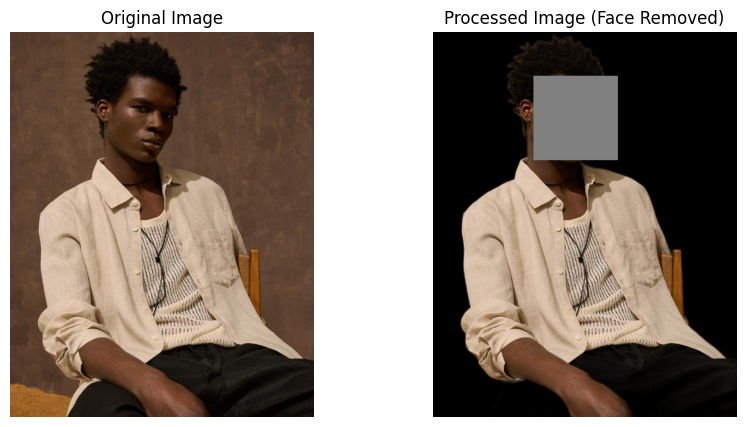

'Extracting dominant colors using histogram analysis...'

"Detected Colors: ['yellow', 'red']"

'Generating fragrance recommendation...'

'Removing background and detecting faces in image...'

'Extracting dominant colors using histogram analysis...'

'Recommended Fragrances:'

,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,Perfumer1,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5,Family,Olfactive Profile
0,verveine agrumes 2015,l occitane en provence,france,unisex,4.32,305,2015,"lemon, grapefruit, orange",lemon verbena,cedar,unknown,citrus,aromatic,unknown,unknown,unknown,citrus,"lemon, grapefruit, orange, lemon verbena, ceda..."
1,morning sunray in sevilla,zara,spain,unisex,3.80,54,2021,"lemon, citrus blossom","rosemary, tarragon, jasmine",incense,alberto morillas,citrus,aromatic,white floral,amber,fresh spicy,citrus,"lemon, citrus blossom, rosemary, tarragon, jas..."
2,oxford,boadicea the victorious,uk,unisex,4.19,26,2013,"lemon, grapefruit, bergamot, clary sage, lavender","neroli, petitgrain, jasmine, mate","musk, vetiver, amber",christian provenzano,citrus,aromatic,fresh spicy,musky,unknown,citrus,"lemon, grapefruit, bergamot, clary sage, laven..."
3,ombrella crash,jacques zolty,france,unisex,3.93,88,2017,"rhuburb, kiwi, pink pepper","watermelon, sea notes, cyclamen, jasmine","lemon, musk, sandalwood",unknown,fruity,aquatic,ozonic,aromatic,marine,fruity,"rhuburb, kiwi, pink pepper, watermelon, sea no..."
4,immortel cedrat,comptoir sud pacifique,france,unisex,3.39,67,2017,"bergamot, lemon verbena","daisy, basil, rosemary","cedar, seaweed, oakmoss",unknown,citrus,aromatic,fresh spicy,woody,marine,citrus,"bergamot, lemon verbena, daisy, basil, rosemar..."


'Running detailed sample test for text-based recommendation...'

'Input description: fresh citrus'

'Searching for perfumes similar to: fresh citrus'

'Recommended Fragrances:'

,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,Perfumer1,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5,Family,Olfactive Profile
0,from paris to new york,zara,spain,men,4.47,129,2018,lemon,ginger,cedar,unknown,citrus,warm spicy,fresh,woody,aromatic,citrus,"lemon, ginger, cedar, citrus, warm spicy, fres..."
1,eau de neroli dore,hermes,france,unisex,3.64,567,2016,bitter orange,neroli,saffron,jean claude ellena,citrus,fresh,white floral,warm spicy,fresh spicy,citrus,"bitter orange, neroli, saffron, citrus, fresh,..."
2,zara orchid 2021,zara,spain,women,3.91,399,2021,bergamot,orchid,vanilla,unknown,citrus,floral,powdery,fresh spicy,sweet,citrus,"bergamot, orchid, vanilla, citrus, floral, pow..."
3,felicita,o boticario,brazil,women,4.56,32,1996,bergamot,vanilla,patchouli,unknown,citrus,patchouli,vanilla,woody,fresh spicy,citrus,"bergamot, vanilla, patchouli, citrus, patchoul..."
4,tempting bergamot,angel schlesser,spain,unisex,4.01,84,2020,calabrian bergamot,hedione,musk,alberto morillas,citrus,floral,fresh,green,fresh spicy,citrus,"calabrian bergamot, hedione, musk, citrus, flo..."
5,blue hole,zara,spain,men,4.36,100,2019,lemon,jasmine,patchouli,unknown,citrus,white floral,patchouli,aromatic,fresh,citrus,"lemon, jasmine, patchouli, citrus, white flora..."
6,very sexy sea,victoria s secret,usa,women,3.96,297,2020,bergamot,neroli,cedar,unknown,citrus,woody,fresh spicy,aromatic,white floral,citrus,"bergamot, neroli, cedar, citrus, woody, fresh ..."
7,vibrant sandalwood,angel schlesser,spain,unisex,3.81,63,2020,bergamot,black tea,sandalwood,alberto morillas,citrus,green,fresh spicy,woody,fresh,citrus,"bergamot, black tea, sandalwood, citrus, green..."
8,crazy pineapple,alexandria fragrances,usa,unisex,4.07,46,2017,"citruses, bergamot","pineapple, green apple","musk, patchouli",hany hafez,citrus,fruity,fresh,sweet,fresh spicy,citrus,"citruses, bergamot, pineapple, green apple, mu..."
9,hyperessence matale 12,pierre guillaume paris,france,unisex,3.72,187,2006,"citruses, jasmine","black tea, pepper, lemon","cedar, musk",pierre guillaume,citrus,fresh spicy,fresh,green,woody,citrus,"citruses, jasmine, black tea, pepper, lemon, c..."


In [25]:
# Execute sample tests
run_sample_tests()

In [22]:
import ipywidgets as widgets
from IPython.display import display

# Upload a test image interactively
uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False)
display(uploader)

if uploader.value:
    uploaded_file = list(uploader.value.values())[0]
    test_image_path = "test_image.png"
    with open(test_image_path, "wb") as f:
        f.write(uploaded_file['content'])
    display(f"Image saved as {test_image_path}")
else:
    display("No file uploaded! Please upload an image first.")


FileUpload(value={}, accept='.png,.jpg,.jpeg', description='Upload')

'No file uploaded! Please upload an image first.'